In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/samples.zip

Streaming output truncated to the last 5000 lines.
  inflating: samples/X/1002.png      
  inflating: samples/X/1003.png      
  inflating: samples/X/1004.png      
  inflating: samples/X/1005.png      
  inflating: samples/X/1006.png      
  inflating: samples/X/1007.png      
  inflating: samples/X/1008.png      
  inflating: samples/X/1009.png      
  inflating: samples/X/1010.png      
  inflating: samples/X/1011.png      
  inflating: samples/X/1012.png      
  inflating: samples/X/1013.png      
  inflating: samples/X/1014.png      
  inflating: samples/X/1015.png      
  inflating: samples/X/1016.png      
  inflating: samples/X/1017.png      
  inflating: samples/X/1018.png      
  inflating: samples/X/1019.png      
  inflating: samples/X/1020.png      
  inflating: samples/X/1021.png      
  inflating: samples/X/1022.png      
  inflating: samples/X/1023.png      
  inflating: samples/X/1024.png      
  inflating: samples/X/1025.png      
  inflating: samples/X/1026.png      

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import skimage.transform
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
batch_size = 16
image_size = 299  # Adjusted input size for InceptionV3
target_dimensions = (image_size, image_size, 3)
num_classes = 29  # 0-28 (A-Z, del, space, nothing)
epochs = 50
train_len = 58000  # Adjust according to your dataset
train_dir = '/content/samples'

In [ ]:
X = np.empty((train_len, image_size, image_size, 3), dtype=np.float32)
y = np.empty((train_len,), dtype=np.int64)
cnt = 0

In [ ]:
label_mapping = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9,
    'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18,
    'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26,
    'space': 27, 'nothing': 28
}

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Use 80% of the data for training
)

Found 46400 images belonging to 29 classes.


In [ ]:
val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use 20% of the data for validation
)

Found 11600 images belonging to 29 classes.


In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
for layer in base_model.layers[-30:]:  # Unfreeze top 30 layers
    layer.trainable = True


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Early stopping and model checkpoints
early_stop = EarlyStopping(monitor='val_loss', patience=4)
checkpoint_filepath = 'inceptionv3_best_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True
)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stop, model_checkpoint_callback],
    verbose=2
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.84647, saving model to inceptionv3_best_model.keras
2900/2900 - 264s - 91ms/step - accuracy: 0.9186 - loss: 0.2941 - val_accuracy: 0.8465 - val_loss: 0.6021
Epoch 2/50

Epoch 2: val_accuracy improved from 0.84647 to 0.84940, saving model to inceptionv3_best_model.keras
2900/2900 - 234s - 81ms/step - accuracy: 0.9773 - loss: 0.0683 - val_accuracy: 0.8494 - val_loss: 0.6717
Epoch 3/50

Epoch 3: val_accuracy did not improve from 0.84940
2900/2900 - 261s - 90ms/step - accuracy: 0.9818 - loss: 0.0542 - val_accuracy: 0.8091 - val_loss: 1.1643
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.84940
2900/2900 - 225s - 78ms/step - accuracy: 0.9848 - loss: 0.0439 - val_accuracy: 0.8355 - val_loss: 1.0982
Epoch 5/50

Epoch 5: val_accuracy did not improve from 0.84940
2900/2900 - 229s - 79ms/step - accuracy: 0.9861 - loss: 0.0407 - val_accuracy: 0.8453 - val_loss: 0.9251


In [ ]:
model.save('ASL_inceptionv3_final.h5')

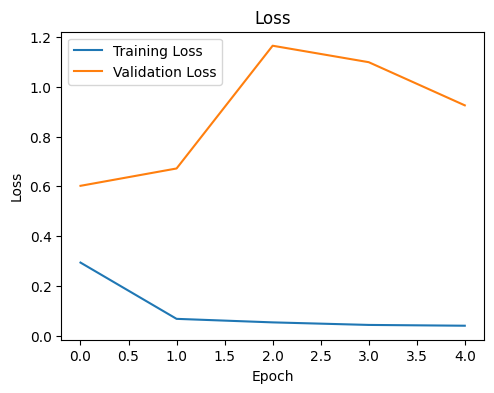

In [ ]:
metrics = pd.DataFrame(history.history)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

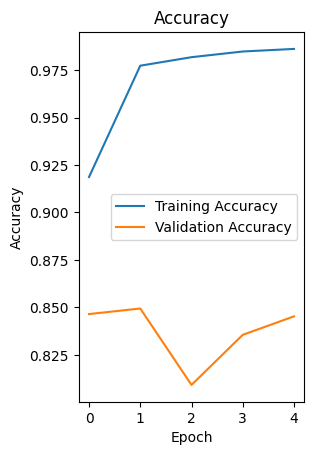

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(metrics['accuracy'], label='Training Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(val_generator)
predictions = np.argmax(predictions, axis=1)
y_val_true = val_generator.classes


725/725 ━━━━━━━━━━━━━━━━━━━━ 49s 58ms/step


In [ ]:
print(classification_report(y_val_true, predictions, target_names=list(train_generator.class_indices.keys())))

              precision    recall  f1-score   support

           A       0.04      0.04      0.04       400
           B       0.02      0.02      0.02       400
           C       0.05      0.05      0.05       400
           D       0.04      0.04      0.04       400
           E       0.05      0.05      0.05       400
           F       0.04      0.04      0.04       400
           G       0.05      0.05      0.05       400
           H       0.02      0.02      0.02       400
           I       0.03      0.03      0.03       400
           J       0.02      0.02      0.02       400
           K       0.03      0.04      0.03       400
           L       0.03      0.03      0.03       400
           M       0.04      0.04      0.04       400
           N       0.02      0.03      0.02       400
           O       0.04      0.04      0.04       400
           P       0.03      0.05      0.04       400
           Q       0.04      0.04      0.04       400
           R       0.05    

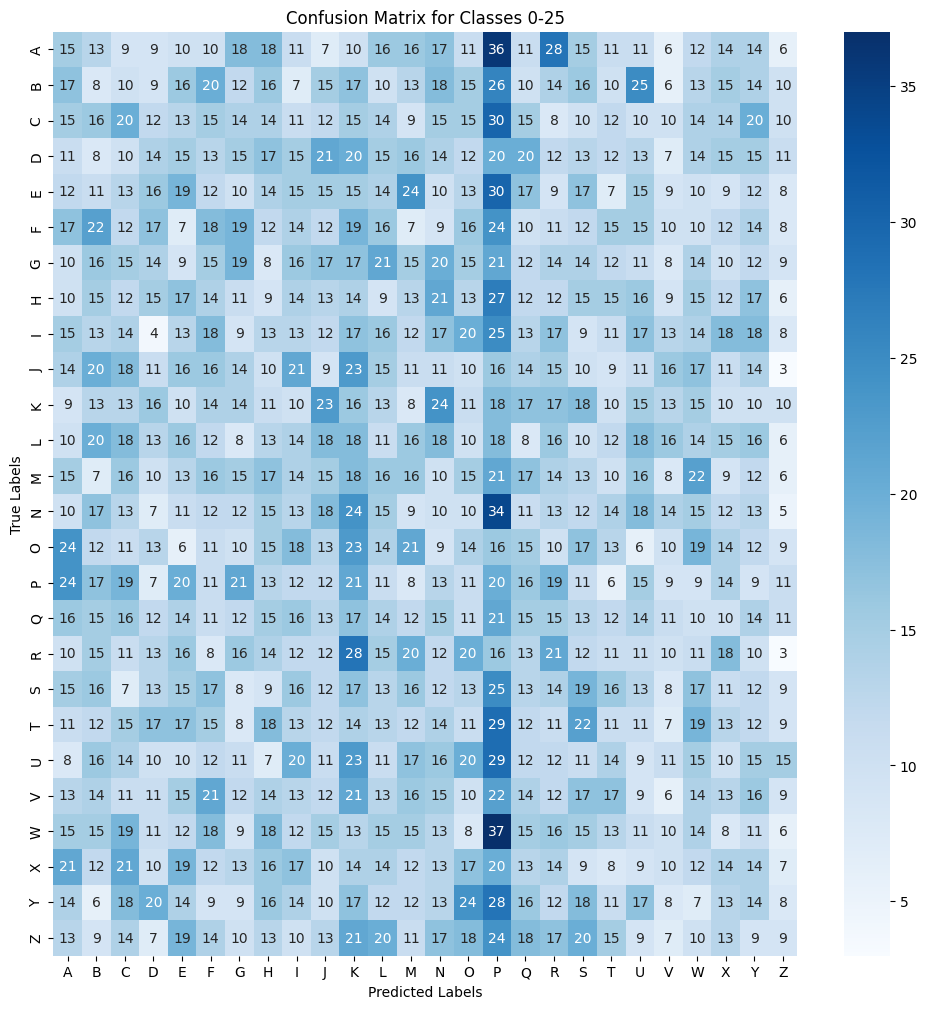

Validation Accuracy: 94.24%


In [ ]:
cm = confusion_matrix(y_val_true, predictions)

# Filter out 'del', 'space', and 'nothing' from the confusion matrix
cm_0_25 = cm[:26, :26]  # Only for classes 0-25 (A-Z)

# Plot Confusion Matrix
plt.figure(figsize=(12, 12))
sns.heatmap(cm_0_25, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(train_generator.class_indices.keys())[:26],
            yticklabels=list(train_generator.class_indices.keys())[:26])
plt.title('Confusion Matrix for Classes 0-25')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Test accuracy
test_loss, test_accuracy = model.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {test_accuracy * 100:.2f}%")